In [243]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torchsummary import summary

In [244]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X).tolist(), np.array(y).tolist()

In [245]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

using device: cuda


In [246]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [247]:
n_epochs = 3000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 30 # number of features
hidden_size = 20 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

seq_len = 64

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

(169, 30) (169, 1)
(169, 30) (169, 1)
(169, 30) (169, 1)


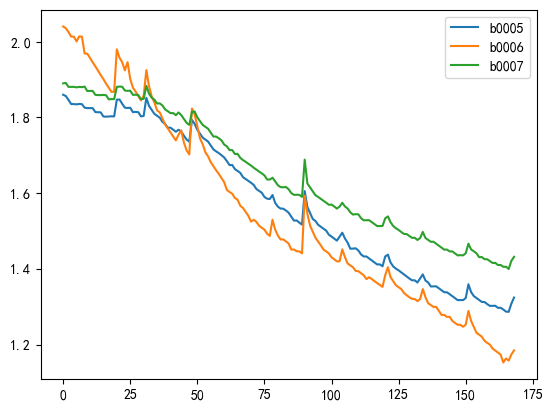

In [248]:
# 读取数据集
battery_names = ["B0005", "B0006", "B0007"]
b5 = np.load("./data/nasa/b0005.npy", allow_pickle=True).item()
b6 = np.load("./data/nasa/b0006.npy", allow_pickle=True).item()
b7 = np.load("./data/nasa/b0007.npy", allow_pickle=True).item()

# 获取模型输入输出
b5_X, b5_y = b5["sequences"], b5["targets"].reshape(-1, 1)
b6_X, b6_y = b6["sequences"], b6["targets"].reshape(-1, 1)
b7_X, b7_y = b7["sequences"], b7["targets"].reshape(-1, 1)
print(b5_X.shape, b5_y.shape)
print(b6_X.shape, b6_y.shape)
print(b7_X.shape, b6_y.shape)
plt.plot(b5_y)
plt.plot(b6_y)
plt.plot(b7_y)
plt.legend(["b0005", "b0006", "b0007"])

b5_X, b5_y = split_sequences(b5_X, b5_y, seq_len, 1)
b6_X, b6_y = split_sequences(b6_X, b6_y, seq_len, 1)
b7_X, b7_y = split_sequences(b7_X, b7_y, seq_len, 1)

# mm = MinMaxScaler(feature_range=(0, 1))
# ss = StandardScaler()

Training Shape: torch.Size([212, 64, 30]) torch.Size([212, 1])
Testing Shape: torch.Size([106, 64, 30]) torch.Size([106, 1])
Epoch: 0, train loss: 2.44771, test loss: 2.30928
Epoch: 100, train loss: 0.01685, test loss: 0.01224
Epoch: 200, train loss: 0.01678, test loss: 0.01233
Epoch: 300, train loss: 0.01669, test loss: 0.01229
Epoch: 400, train loss: 0.01490, test loss: 0.01111
Epoch: 500, train loss: 0.01249, test loss: 0.00923
Epoch: 600, train loss: 0.00721, test loss: 0.00486
Epoch: 700, train loss: 0.00159, test loss: 0.00066
Epoch: 800, train loss: 0.00075, test loss: 0.00086
Epoch: 900, train loss: 0.00065, test loss: 0.00076
Epoch: 1000, train loss: 0.00060, test loss: 0.00063
Epoch: 1100, train loss: 0.00057, test loss: 0.00086
Epoch: 1200, train loss: 0.00055, test loss: 0.00066
Epoch: 1300, train loss: 0.00059, test loss: 0.00096
Epoch: 1400, train loss: 0.00055, test loss: 0.00060
Epoch: 1500, train loss: 0.00055, test loss: 0.00098
Epoch: 1600, train loss: 0.00052, test 

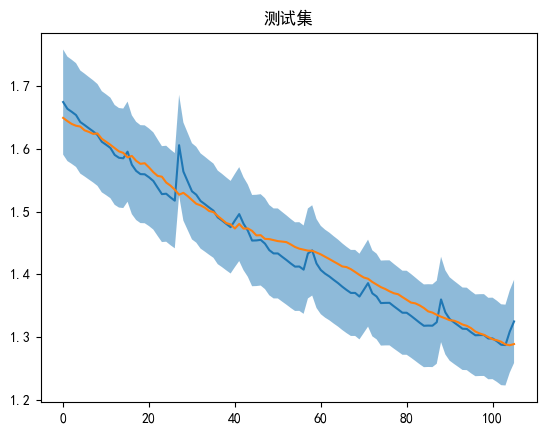

In [249]:
# b5为测试集
X_train, y_train = np.array(b6_X + b7_X), np.array(b6_y + b7_y)
X_test, y_test = np.array(b5_X), np.array(b5_y)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train,
              y_train=y_train,
              X_test=X_test,
              y_test=y_test)

# 可视化
y_test = y_test.flatten()
cycle = np.array(range(len(y_test)))
y1 = y_test * (1 - 0.05)
y2 = y_test * (1 + 0.05)
pred = lstm(X_test)
pred = pred.data.numpy()
plt.title("测试集")
plt.plot(y_test)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(pred)
print(y1[0])
print(y_test[0])

Training Shape: torch.Size([212, 64, 30]) torch.Size([212, 1])
Testing Shape: torch.Size([106, 64, 30]) torch.Size([106, 1])
Epoch: 0, train loss: 0.00035, test loss: 0.00135
Epoch: 100, train loss: 0.00024, test loss: 0.00101
Epoch: 200, train loss: 0.00023, test loss: 0.00100
Epoch: 300, train loss: 0.00022, test loss: 0.00102
Epoch: 400, train loss: 0.00021, test loss: 0.00104
Epoch: 500, train loss: 0.00021, test loss: 0.00104
Epoch: 600, train loss: 0.00024, test loss: 0.00128
Epoch: 700, train loss: 0.00020, test loss: 0.00108
Epoch: 800, train loss: 0.00019, test loss: 0.00109
Epoch: 900, train loss: 0.00024, test loss: 0.00135
Epoch: 1000, train loss: 0.00019, test loss: 0.00113
Epoch: 1100, train loss: 0.00018, test loss: 0.00111
Epoch: 1200, train loss: 0.00021, test loss: 0.00108
Epoch: 1300, train loss: 0.00020, test loss: 0.00137
Epoch: 1400, train loss: 0.00017, test loss: 0.00117
Epoch: 1500, train loss: 0.00018, test loss: 0.00133
Epoch: 1600, train loss: 0.00017, test 

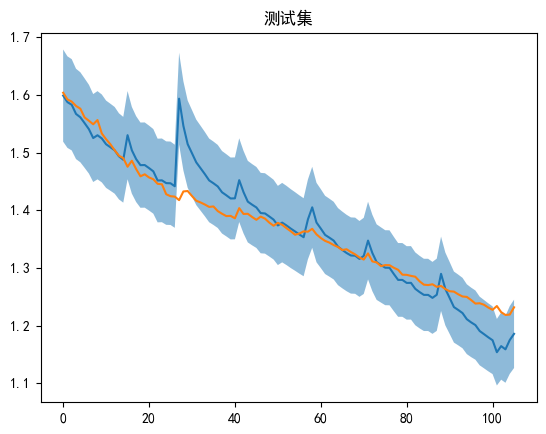

In [250]:
# b6为测试集
X_train, y_train = np.array(b7_X + b5_X), np.array(b7_y + b5_y)
X_test, y_test = np.array(b6_X), np.array(b6_y)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train,
              y_train=y_train,
              X_test=X_test,
              y_test=y_test)

# 可视化
y_test = y_test.flatten()
cycle = np.array(range(len(y_test)))
y1 = y_test * (1 - 0.05)
y2 = y_test * (1 + 0.05)
pred = lstm(X_test)
pred = pred.data.numpy()
plt.title("测试集")
plt.plot(y_test)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(pred)
print(y1[0])
print(y_test[0])

Training Shape: torch.Size([212, 64, 30]) torch.Size([212, 1])
Testing Shape: torch.Size([106, 64, 30]) torch.Size([106, 1])
Epoch: 0, train loss: 0.00073, test loss: 0.00027
Epoch: 100, train loss: 0.00095, test loss: 0.00159
Epoch: 200, train loss: 0.00078, test loss: 0.00130
Epoch: 300, train loss: 0.00072, test loss: 0.00114
Epoch: 400, train loss: 0.00068, test loss: 0.00117
Epoch: 500, train loss: 0.00063, test loss: 0.00096
Epoch: 600, train loss: 0.00062, test loss: 0.00122
Epoch: 700, train loss: 0.00057, test loss: 0.00084
Epoch: 800, train loss: 0.00058, test loss: 0.00075
Epoch: 900, train loss: 0.00059, test loss: 0.00091
Epoch: 1000, train loss: 0.00051, test loss: 0.00068
Epoch: 1100, train loss: 0.00047, test loss: 0.00054
Epoch: 1200, train loss: 0.00045, test loss: 0.00046
Epoch: 1300, train loss: 0.00046, test loss: 0.00046
Epoch: 1400, train loss: 0.00053, test loss: 0.00050
Epoch: 1500, train loss: 0.00042, test loss: 0.00042
Epoch: 1600, train loss: 0.00044, test 

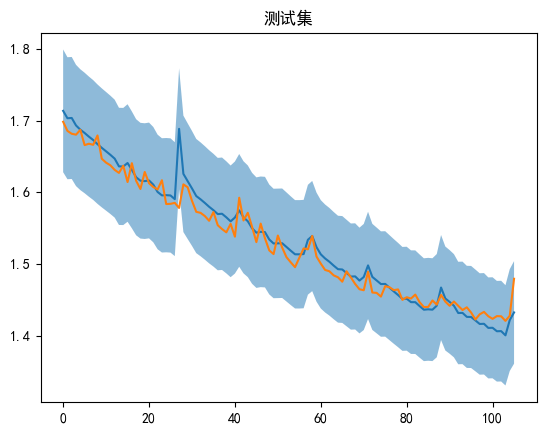

In [251]:
# b7为测试集
X_train, y_train = np.array(b6_X + b5_X), np.array(b6_y + b5_y)
X_test, y_test = np.array(b7_X), np.array(b7_y)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train,
              y_train=y_train,
              X_test=X_test,
              y_test=y_test)

# 可视化
y_test = y_test.flatten()
cycle = np.array(range(len(y_test)))
y1 = y_test * (1 - 0.05)
y2 = y_test * (1 + 0.05)
pred = lstm(X_test)
pred = pred.data.numpy()
plt.title("测试集")
plt.plot(y_test)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(pred)
print(y1[0])
print(y_test[0])